In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('train.csv')

# Display the first 5 rows of the data
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


C:\Users\Umesh eshwar reddy\AppData\Local\Temp\ipykernel_9000\1960535816.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['sales'].resample('M').sum()


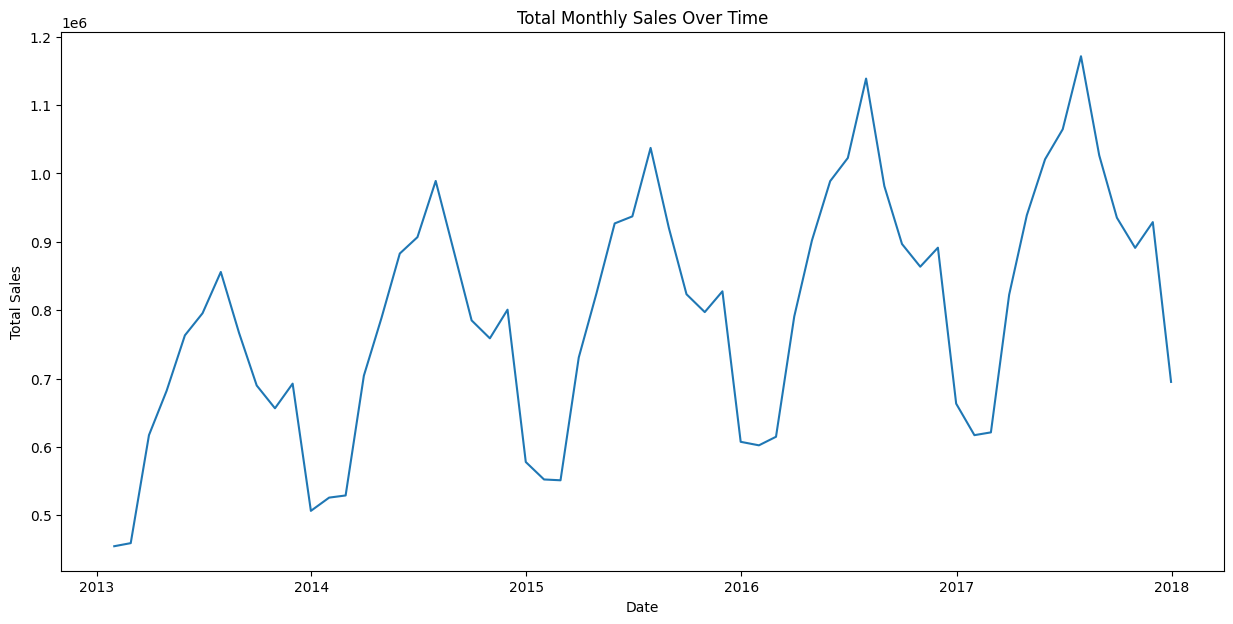

In [5]:
# To make plotting easier, let's set the 'date' column as our index
df.set_index('date', inplace=True)

# Resample the data to get the sum of sales for each month
monthly_sales = df['sales'].resample('M').sum()

# Create the plot
plt.figure(figsize=(15, 7))
plt.title('Total Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
sns.lineplot(data=monthly_sales)
plt.show()

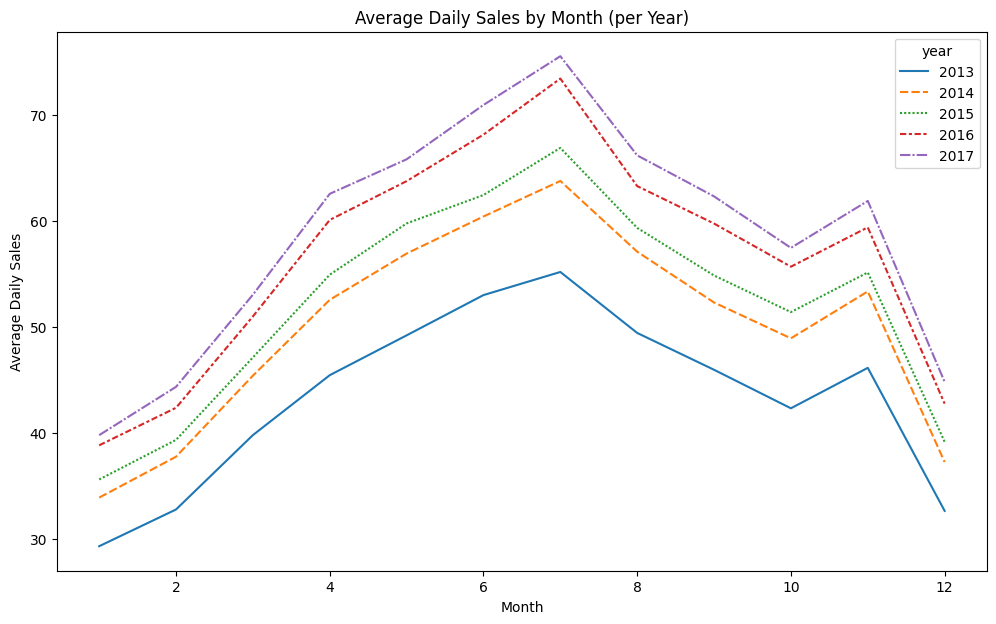

In [6]:
# First, let's reset the index to get 'date' back as a column
df.reset_index(inplace=True)

# Create 'month' and 'year' columns for easier grouping
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Create a pivot table to see average sales by month for each year
pivot = df.pivot_table(index='month', columns='year', values='sales', aggfunc='mean')

# Plot the pivot table
plt.figure(figsize=(12, 7))
plt.title('Average Daily Sales by Month (per Year)')
sns.lineplot(data=pivot)
plt.ylabel('Average Daily Sales')
plt.xlabel('Month')
plt.show()

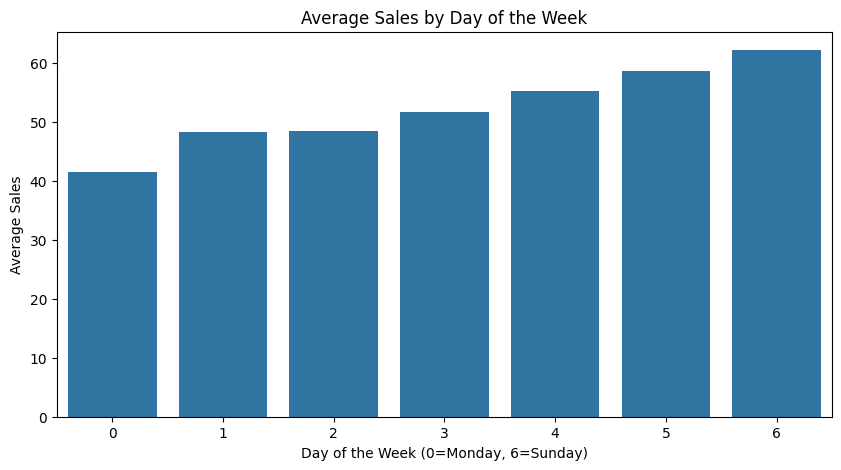

In [7]:
# Create a 'day_of_week' column (Monday=0, Sunday=6)
df['day_of_week'] = df['date'].dt.dayofweek

# Group by day of the week and calculate average sales
avg_sales_by_day = df.groupby('day_of_week')['sales'].mean()

# Plot the results
plt.figure(figsize=(10, 5))
plt.title('Average Sales by Day of the Week')
sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values)
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.show()

In [8]:
# We already created these in the previous step, but let's ensure they are all there
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

# Now, we define our features (X) and our target (y)
# The features are the inputs the model will use to make predictions.
features = ['store', 'item', 'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter']
X = df[features]

# The target is the value we want to predict.
y = df['sales']

# Let's look at our newly created feature set
X.head()

,store,item,month,year,day_of_week,day_of_year,week_of_year,quarter
0,1,1,1,2013,1,1,1,1
1,1,1,1,2013,2,2,1,1
2,1,1,1,2013,3,3,1,1
3,1,1,1,2013,4,4,1,1
4,1,1,1,2013,5,5,1,1


In [9]:
# The original DataFrame `df` still has our date column, which we'll use for the split.
# We'll test our model on the last 3 months of data (Oct, Nov, Dec 2017)
split_date = '2017-10-01'
train_data = df[df['date'] < split_date]
test_data = df[df['date'] >= split_date]

# Now create the feature (X) and target (y) sets for both training and testing
X_train = train_data[features]
y_train = train_data['sales']

X_test = test_data[features]
y_test = test_data['sales']

# Let's check the size of our sets to confirm the split
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 867000 rows
Testing set size: 46000 rows


In [10]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# 1. Initialize the model with some good starting parameters
model = lgb.LGBMRegressor(
    objective='regression_l1', # MAE loss function
    n_estimators=2000,         # High number of trees, we'll use early stopping
    learning_rate=0.01,
    n_jobs=-1,                 # Use all available CPU cores
    random_state=42
)

# 2. Train the model
print("Training the LightGBM model...")
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)], # Data to evaluate on
    eval_metric='mae',          # Metric for evaluation
    callbacks=[lgb.early_stopping(100, verbose=True)] # Stop if MAE doesn't improve for 100 rounds
)
print("Model training complete.")

Training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 8
[LightGBM] [Info] Start training from score 47.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l1: 6.26007
Model training complete.


In [12]:
# Generate predictions for the test set
predictions = model.predict(X_test)

# The 'predictions' variable now holds our model's forecast
print(predictions[:5]) # Print the first 5 predictions

[27.15581767 17.53948081 20.52021037 20.52612737 21.9159339 ]


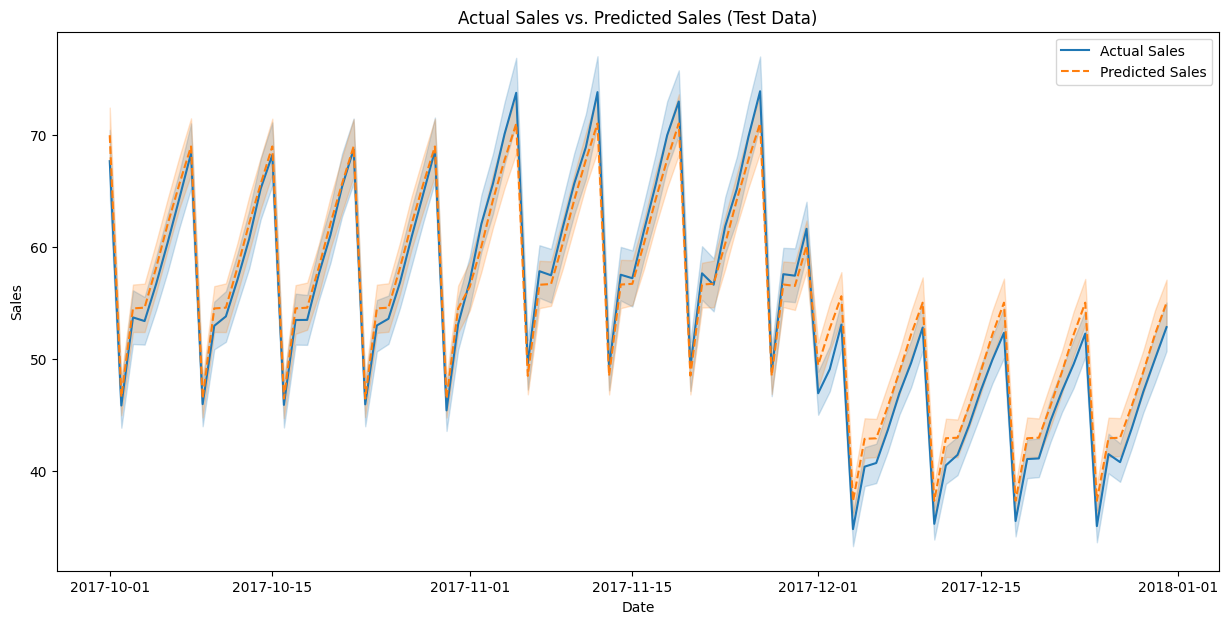

In [13]:
# Create a new DataFrame to easily plot the actual vs. predicted values
results_df = pd.DataFrame({'date': test_data['date'], 'actual_sales': y_test, 'predicted_sales': predictions})

# Create the plot
plt.figure(figsize=(15, 7))
plt.title('Actual Sales vs. Predicted Sales (Test Data)')

# Plot actual sales
sns.lineplot(data=results_df, x='date', y='actual_sales', label='Actual Sales')

# Plot predicted sales
sns.lineplot(data=results_df, x='date', y='predicted_sales', label='Predicted Sales', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print(f"The Mean Absolute Error (MAE) on the test set is: {mae:.2f}")

The Mean Absolute Error (MAE) on the test set is: 6.26


In [15]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'lgbm_forecaster.pkl')

print("Model saved successfully as lgbm_forecaster.pkl")

Model saved successfully as lgbm_forecaster.pkl
